In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
df_oz= pd.read_csv('./datasets/LA_ozone_site_0002.csv')

cols_to_drop= ['Source', 'Site ID', 'POC','UNITS', 'Site Name', 'DAILY_OBS_COUNT', 'PERCENT_COMPLETE',
               'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC', 'CBSA_CODE', 'CBSA_NAME', 'STATE_CODE', 'STATE',
               'COUNTY_CODE', 'COUNTY', 'SITE_LATITUDE', 'SITE_LONGITUDE']

df_oz  = df_oz.drop(columns=cols_to_drop)
df_oz.Date = pd.to_datetime(df_oz.Date)

In [3]:
df_oz.head(2)

,Date,Daily Max 8-hour Ozone Concentration,DAILY_AQI_VALUE
0,1996-01-01,0.031,29
1,1996-01-02,0.016,15


In [4]:
# Checking for missing dates
df_tmp = df_oz.set_index('Date') # the following command requires to have a index set to Date column
missing_dates = pd.date_range(df_tmp.index.min(), df_tmp.index.max()).difference(df_tmp.index)
print (missing_dates)
print ('There are total : %d number of missing dates in the dataset.' %len(missing_dates))

DatetimeIndex(['1996-12-05', '1996-12-19', '1996-12-31', '1997-02-13',
               '1997-02-14', '1997-03-21', '1997-03-22', '1997-03-23',
               '1997-03-24', '1997-03-25',
               ...
               '2018-12-31', '2019-05-24', '2019-05-28', '2019-05-29',
               '2019-05-31', '2019-08-30', '2020-02-21', '2020-02-25',
               '2020-03-19', '2020-03-24'],
              dtype='datetime64[ns]', length=268, freq=None)
There are total : 268 number of missing dates in the dataset.


### Filling the missing data from last available data

In [5]:
# first set the index as Date
df_oz = df_oz.set_index('Date')
# insert all the missing dates with Nans
df_oz = df_oz.reindex(  pd.date_range(df_oz.index.min(), df_oz.index.max())  ) 
# fill those missing dates with the last known date
df_oz.ffill(axis=0, inplace=True)  
# Now move the Date index as one of the columns, easier for later analysis
df_oz = df_oz.rename_axis('Date').reset_index()  
df_oz.head()

,Date,Daily Max 8-hour Ozone Concentration,DAILY_AQI_VALUE
0,1996-01-01,0.031,29.0
1,1996-01-02,0.016,15.0
2,1996-01-03,0.013,12.0
3,1996-01-04,0.021,19.0
4,1996-01-05,0.015,14.0


In [6]:
# check if there are any null value
df_oz.isnull().any() 

Date                                    False
Daily Max 8-hour Ozone Concentration    False
DAILY_AQI_VALUE                         False
dtype: bool

In [7]:
# Train test split
df_train_oz = df_oz.loc[ df_oz.Date < datetime(2018, 1, 1)  ].copy()
df_test_oz  = df_oz.loc[ df_oz.Date >= datetime(2018, 1, 1)  ].copy()

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


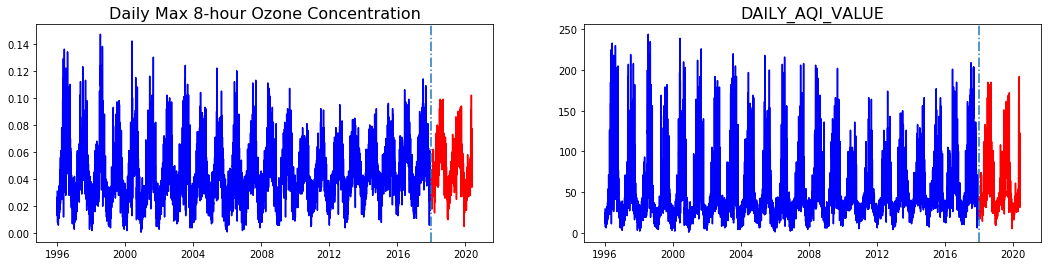

In [8]:
plt.figure(figsize=(18,4))

cols= ['Daily Max 8-hour Ozone Concentration', 'DAILY_AQI_VALUE']

for i, col in enumerate(cols):
    plt.subplot(121+i)
    plt.title(col, fontsize=16)
    plt.plot(df_train_oz.Date, df_train_oz[col], color='blue')
    plt.plot(df_test_oz.Date, df_test_oz[col], color='red')
    plt.axvline(x=datetime(2018, 1, 1), ls='-.' )

## Seasonal Naive Method

In [9]:
def seasonal_naive(dff, df_train, df_test, n_period, cols):
    df_pred = dff.copy()
    for date in df_test.Date.values:
        indx = df_pred.loc[ dff.Date == date  ].index[0] - n_period*183
        for col in cols:
            preds = df_pred[col][indx]
            df_pred.loc[ dff.Date == date, col ] = preds
    return df_pred

n_period=1
cols= ['Daily Max 8-hour Ozone Concentration', 'DAILY_AQI_VALUE']
df_pred = seasonal_naive(df_oz, df_train_oz, df_test_oz, n_period, cols)

In [11]:
df_test_oz.tail(1)

,Date,Daily Max 8-hour Ozone Concentration,DAILY_AQI_VALUE
8911,2020-05-25,0.077,122.0


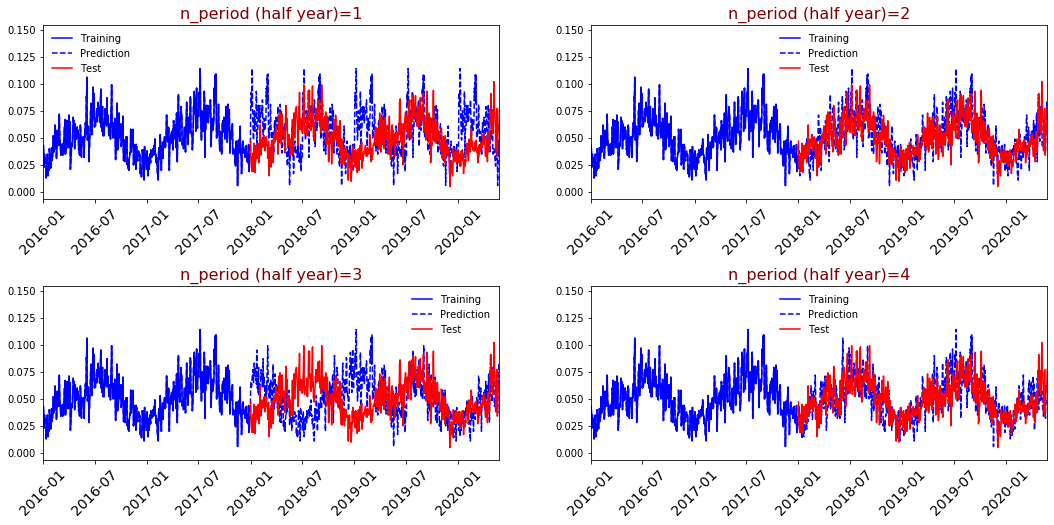

In [12]:
cols= ['Daily Max 8-hour Ozone Concentration', 'DAILY_AQI_VALUE']
plt.figure(figsize=(18,8))
for i, n_period in enumerate([1, 2, 3, 4]):
    plt.subplot(2,2,i+1)
    plt.title('n_period (half year)='+str(n_period), fontsize=16, color='maroon' )
    
    df_pred_oz = seasonal_naive(df_oz, df_train_oz, df_test_oz, n_period, cols=cols)
    plt.plot(df_train_oz.Date, df_train_oz['Daily Max 8-hour Ozone Concentration'], 'b', label='Training')
    plt.plot(df_pred_oz.Date,  df_pred_oz['Daily Max 8-hour Ozone Concentration'], 'b--', label='Prediction')
    plt.plot(df_test_oz.Date,  df_test_oz['Daily Max 8-hour Ozone Concentration'], 'r', label='Test')
    plt.legend(frameon=False)
    plt.xlim([datetime(2016,1,1), datetime(2020,5,25) ]);
    plt.xticks(fontsize=14, rotation=45);
    plt.subplots_adjust(hspace=0.5)

In [13]:
def make_lag_df(df, feature, lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

def get_autocorr(df, feature, lag):
    df = make_lag_df(df, feature, lag)
    mean_y = df[feature].mean()
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

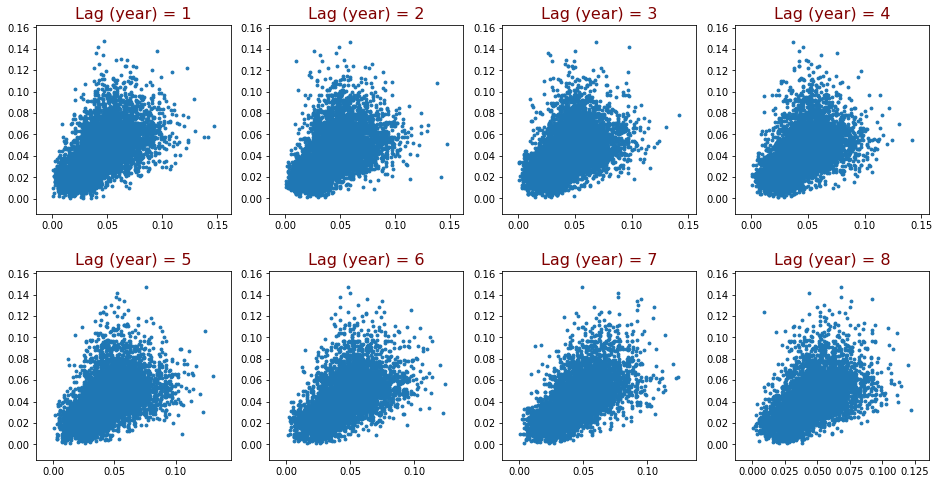

In [16]:
def Plot_Lag(df, feature, Nplots=8):
    plt.figure(figsize=(16,8))
    for i in range(1,Nplots+1):
        lag_df = make_lag_df(df, feature, i*365)

        plt.subplot(2,4, i)
        plt.title('Lag (year) = '+str(i), fontsize=16, color='maroon')
        plt.scatter(lag_df[feature], lag_df[feature+'_lag'], s=8)
        plt.subplots_adjust(hspace=0.3)
    plt.show()

feature = 'Daily Max 8-hour Ozone Concentration'
Plot_Lag(df_oz, feature)

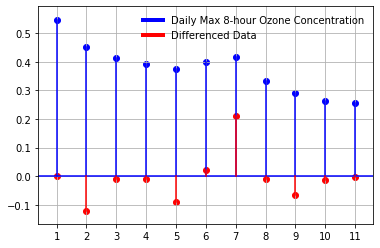

In [20]:
def Plot_autocorrelation(df, feature, N_year):
    autos = []
    N_year=12;
    for i in range(1,N_year,1):
        autos.append(get_autocorr(df,feature,i*365))
    plt.scatter(range(1,N_year,1), autos, c='b')

    for i in range(1,N_year,1):
        plt.plot(i*np.ones(2),[0,autos[i-1]],'b')

    plt.axhline(y=0, c='b')

    auto_diff = []
    diff_data = df.diff().dropna().reset_index(drop=True)

    for i in range(1,N_year,1):
        auto_diff.append(get_autocorr(diff_data,feature,i*365))

    plt.scatter(range(1,N_year,1), auto_diff, c='r')

    for i in range(1,N_year,1):
        plt.plot(i*np.ones(2),[0,auto_diff[i-1]],'r')
    plt.grid()

    plt.xticks(range(1,N_year));
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color="blue", lw=4),
                    Line2D([0], [0], color="red", lw=4)]

    plt.legend(custom_lines, [feature, 'Differenced Data'], frameon=False);

feature = 'Daily Max 8-hour Ozone Concentration'
Plot_autocorrelation(df_oz, feature, N_year=12)